In [100]:
# Import libraries
import numpy as np
import matplotlib.pyplot  as plt
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, Lasso, Ridge
from sklearn.model_selection import LeaveOneOut, LeavePOut
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold

In [101]:
# Load data arrays
x = np.load('X_train_regression1.npy')
x = np.concatenate((np.ones((15,1)), x), axis=1)
y = np.load('y_train_regression1.npy')
xx = np.load('X_test_regression1.npy')
#print(x.shape, y.shape, xx.shape)
xx = np.concatenate((np.ones((1000,1)), xx), axis=1)

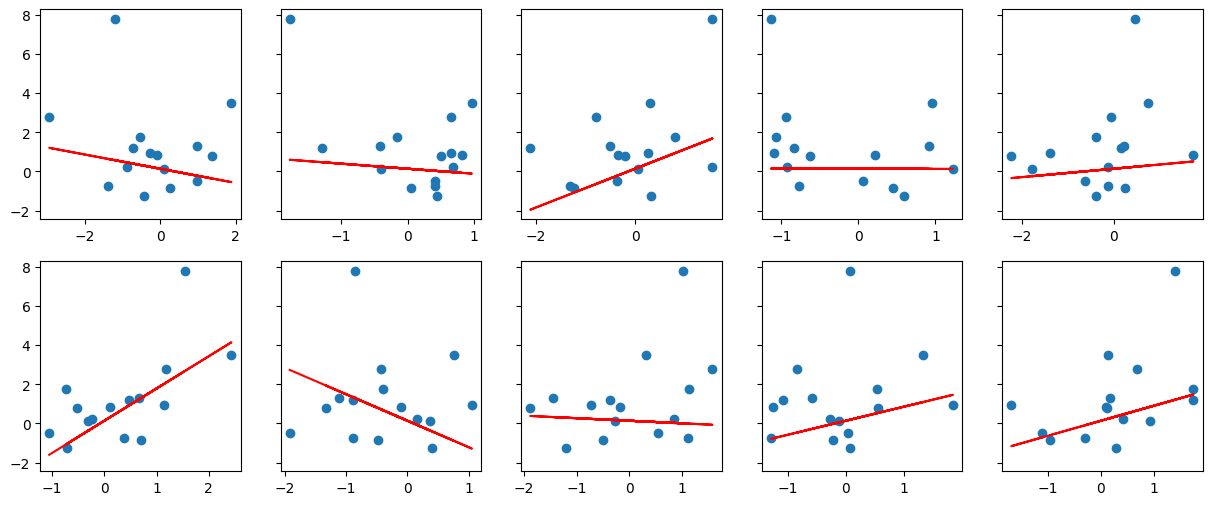

In [102]:
# Visualize data related to each feature in relation to a linear regression
y_estimated = np.zeros((15,10))
beta = np.dot(np.dot(np.linalg.inv(np.dot(np.transpose(x),x)) , np.transpose(x)), y)
features = range(10)
for i in features:
    y_estimated[:,i] = beta[0] + beta[i+1]*x[:,i+1]

fig, axs = plt.subplots(2, 5, figsize=(15,6), sharey=True)
for i, ax in enumerate(axs.flat):
    ax.scatter(x[:,i+1], y)
    ax.plot(x[:,i+1], y_estimated[:,i], color='red')


In [103]:
# 1.1 Linear Model without Cross Validation via Algebra
y_avg = y.mean()
y_avg_mtx = np.ones((15,1)) * y_avg
y_estimated = np.zeros((15,1))
beta = np.dot(np.dot(np.linalg.inv(np.dot(np.transpose(x[:14,:]),x[:14,:])) , np.transpose(x[:14,:])), y[:14,:])

samples = range(15)
features = range(11)
for j in samples:
    for i in features:
        y_estimated[j] += beta[i]*x[j,i]

SS_tot = sum((y - y_avg_mtx)**2)
SS_res = sum((y - y_estimated)**2)

coeff_det = 1 - SS_res/SS_tot
print(f"sse is: {SS_res[0]}")
print(f"r^2 is: {coeff_det[0]}")

sse is: 5.3213612200795986
r^2 is: 0.9245949461379536


In [104]:
# 1.1 Linear Model without Cross Validation using scikit-learn
regr = LinearRegression()
regr.fit(x[:14,:],y[:14,:])
y_pred = regr.predict(x)

y_avg = y.mean()
y_avg_mtx = np.ones((15,1)) * y_avg

SS_tot = sum((y - y_avg_mtx)**2)
SS_res = sum((y - y_pred)**2)
coeff_det = 1 - SS_res/SS_tot
print(regr.coef_.shape)
print(f"sse is: {SS_res[0]}")
print(f"r^2 is: {coeff_det[0]}")

(1, 11)
sse is: 5.3213612200795986
r^2 is: 0.9245949461379536


In [105]:
# 1.2 Linear Regression with Cross Validation(LOO)
loo = LeaveOneOut()
predicted_values = []
sse_values = []
for train_index, test_index in loo.split(x):
    x_train, x_test = x[train_index], x[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    model = LinearRegression()
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    predicted_values.append(y_pred[0])
    sse_fold = np.sum((y_test - y_pred)**2)
    sse_values.append(sse_fold)
    
mse = np.mean(sse_values)
ss_tot = sum((y - np.mean(y))**2)
r_squared = 1 - mse/ss_tot
print(f"sse is: {mse}")
print(f"r^2 is: {r_squared[0]}")

sse is: 7.864171987128431
r^2 is: 0.88856266512557


In [106]:
# Polynomial Model without Cross Validation
degree = 10
exp = np.arange(11)
for i in range(0,4):
    exp = np.vstack((exp,exp))
exp = np.delete(exp,0,0)

x_poly = np.power(x,exp)
beta = np.dot(np.dot(np.linalg.inv(np.dot(np.transpose(x_poly), x_poly)), np.transpose(x_poly)), y)
y_estimated = np.dot(x_poly, beta)

y_avg = y.mean()
y_avg_mtx = np.ones((15,1)) * y_avg
SS_tot = sum((y - y_avg_mtx)**2)
SS_res = sum((y - y_estimated)**2)

r_squared = 1 - SS_res / SS_tot
print(f"sse is: {SS_res[0]}")
print(f"r^2 is: {r_squared[0]}")

sse is: 2.4381579647304337
r^2 is: 0.965450676048651


In [107]:
# Polynomial Model with Cross Validation(loo) via Algebra
exp = np.arange(11)
for i in range(0,4):
    exp = np.vstack((exp,exp))
exp = np.delete(exp,0,0)
x_poly = np.power(x,exp)

sse_values = []
loo = LeaveOneOut()
for train_index, test_index in loo.split(x):
    x_train, x_test = x_poly[train_index], x_poly[test_index]
    y_train, y_test = y[train_index], y[test_index]
        
    coef = np.dot(np.dot(np.linalg.inv(np.dot(np.transpose(x_train), x_train)), np.transpose(x_train)), y_train)
    y_pred = np.dot(x_test, coef)

    sse_fold = np.sum((y_test - y_pred)**2)
    sse_values.append(sse_fold)

sse = np.mean(sse_values)
ss_tot = sum((y-np.mean(y))**2)

r_2 = 1 - sse / ss_tot
print(f"sse is: {sse}")
print(f"r^2 is: {r_2[0]}")

sse is: 375.0385714694054
r^2 is: -4.314392786433023


In [108]:
# Polynomial Model with Cross Validation(loo) using sklearn
sse_values = []
loo = LeaveOneOut()
poly = PolynomialFeatures(degree=1, include_bias=False)
x = np.delete(x,0,1)
for train_index, test_index in loo.split(x):
    x_train, x_test = x_poly[train_index], x_poly[test_index]
    y_train, y_test = y[train_index], y[test_index]

    poly_features = poly.fit_transform(x_train)
    poly_reg_model = LinearRegression()
    poly_reg_model.fit(poly_features, y_train)
    y_pred = poly_reg_model.predict(x_test)

    sse_fold = sum((y_test - y_pred)**2)
    sse_values.append(sse_fold)

mse = np.mean(sse_values)
ss_tot = sum((y - np.mean(y))**2)
r_2 = 1 - mse/ss_tot

print(f"sse is: {sse}")
print(f"r^2 is: {r_squared[0]}")

sse is: 375.0385714694054
r^2 is: 0.965450676048651


In [109]:
# Lasso Regression with Cross Validation(LOO)
lpo = LeavePOut(1)
lasso_cv = LassoCV(alphas = np.logspace(-4,0,2000), fit_intercept=True, cv=lpo)
lasso_cv.fit(x,y.flat)
alpha = lasso_cv.alpha_
coeffs = lasso_cv.coef_
r_squared = lasso_cv.score(x,y)
print(coeffs)
print(f"alpha is: {alpha}")
print(f"r^2 is: {r_squared}")

[-0.         -0.37885985  0.97746686 -0.21999625  0.          1.5692901
 -0.73696912  0.          0.03048449  0.57664925]
alpha is: 0.08699008092678392
r^2 is: 0.9061141919899999


In [110]:
# Lasso Regression with Cross Validation(LOO), calculated SSE
loo = LeaveOneOut()
mse_values = []
alpha_min = 0
alphas = np.logspace(-3,-1,5000)
for alpha in alphas:
    sse_values = []
    for train_index, test_index in loo.split(x):
        x_train, x_test = x[train_index], x[test_index]
        y_train, y_test = y[train_index], y[test_index]
        lasso = Lasso(alpha=alpha)
        lasso.fit(x_train, y_train)
        
        y_pred = lasso.predict(x_test)
        sse_fold = np.sum((y_test - y_pred)**2)
        sse_values.append(sse_fold)

    mse = np.mean(sse_values)
    mse_values.append(mse)
alpha_min = alphas[np.array(mse_values).argmin()]
ss_tot = sum((y-np.mean(y))**2)
r_squared = 1 - np.min(mse_values)/ss_tot
print(f"best alpha is: {alpha_min}")
print(f"mse is: {np.min(mse_values)}")
print(f"r^2 is: {r_squared[0]}")

best alpha is: 0.08709395198612588
mse is: 2.8059151182995477
r^2 is: 0.9602394628221569


In [111]:
# Defining useless features based on Lasso's output
loo = LeaveOneOut()
scaler = StandardScaler()
scaler.fit(x)
x_norm = scaler.transform(x)
scaler.fit(y)
y_norm = scaler.transform(y)

sse_values = []
coef_values = []
for train_index, test_index in loo.split(x):
    x_train, x_test = x[train_index], x[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    lasso = Lasso(alpha=alpha_min)
    lasso.fit(x_norm, y_norm)
    coef_values.append(lasso.coef_)
    lasso.fit(x_train, y_train)
    y_pred = lasso.predict(x_test)
    sse_fold = np.sum((y_test - y_pred)**2)
    sse_values.append(sse_fold)

mse = np.mean(sse_values)
ss_tot = sum((y-np.mean(y))**2)
r_squared = 1 - mse/ss_tot
overall_coef = np.mean(coef_values, axis=0)
useless_features = [element for element,val in enumerate(overall_coef) if abs(val)==0]
print(useless_features)
print(overall_coef)

[0, 4, 7, 8]
[ 0.         -0.16777999  0.37440072 -0.07529116  0.          0.59621198
 -0.17058537  0.          0.          0.20331462]


In [115]:
# [ FINAL MODEL ] Linear Regression with CV (loo) excluding useless features
print("FINAL MODEL\n")

x_del = np.copy(x)
x_del = np.delete(x_del, useless_features, 1)
print("Features removed:",useless_features)

loo = LeaveOneOut()
predicted_values = []
coef_values = []
for train_index, test_index in loo.split(x_del):
    x_train, x_test = x_del[train_index], x_del[test_index]
    y_train, y_test = y[train_index], y[test_index]
    model = LinearRegression()
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    predicted_values.append(y_pred[0])
    coef_values.append(model.coef_)

mean_coef = np.mean(coef_values, axis=0)
sse = np.mean((y - predicted_values) ** 2)
ss_tot = sum((y - y.mean())**2)
r_squared = 1 - sse/ss_tot
print(mean_coef)
print(f"mse is: {sse}")
print(f"r^2 is: {r_squared[0]}")


# Previewing test data based on a linear model with restricted features referenced by the Lasso method
print("Using this model for the final submission!!")
x_del = np.copy(xx)
x_del = np.delete(x_del, [0,1,5,8,9], 1)

model.coef_ = mean_coef
y_pred = model.predict(x_del)
np.save('test.npy', y_pred)


FINAL MODEL

Features removed: [0, 4, 7, 8]
[[-0.32372794  1.12568605 -0.24639451  1.74617076 -1.00690017  0.65894243]]
mse is: 1.8386650963553752
r^2 is: 0.9739456438135076
Using this model for the final submission!!


In [116]:
# Linear Regression with KFold excluding useless features

useless_features = [0,4,7,8]

x_del = np.copy(x)

x_del = np.delete(x_del, useless_features, 1)

kf = KFold(n_splits=5)
#kf = KFold(n_splits=5, shuffle=True, random_state=41)
sse_values = []

for i, (train_index, test_index) in enumerate(kf.split(x_del)):
    x_train, x_test = x_del[train_index], x_del[test_index]
    y_train, y_test = y[train_index], y[test_index]
    print(f"Fold {i+1}: train index: {train_index}, test index: {test_index}")
    model = LinearRegression()
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    sse_fold = np.sum((y_test - y_pred)**2)
    sse_values.append(sse_fold)
    print(f"SSE for Fold {i+1}: {sse_fold}\n")

sse = np.mean(sse_values)
ss_tot = sum((y - y.mean())**2)
r_squared = 1 - sse/ss_tot
print("mse is:", sse)
print("r^2 is:", r_squared)

Fold 1: train index: [ 3  4  5  6  7  8  9 10 11 12 13 14], test index: [0 1 2]
SSE for Fold 1: 8.237201158278097

Fold 2: train index: [ 0  1  2  6  7  8  9 10 11 12 13 14], test index: [3 4 5]
SSE for Fold 2: 4.443624446654116

Fold 3: train index: [ 0  1  2  3  4  5  9 10 11 12 13 14], test index: [6 7 8]
SSE for Fold 3: 1.959129771969635

Fold 4: train index: [ 0  1  2  3  4  5  6  7  8 12 13 14], test index: [ 9 10 11]
SSE for Fold 4: 12.14545633589828

Fold 5: train index: [ 0  1  2  3  4  5  6  7  8  9 10 11], test index: [12 13 14]
SSE for Fold 5: 5.175702978647053

mse is: 6.392222938289436
r^2 is: [0.90942056]


In [80]:
# Linear Regression with CV(lpo) excluding useless features
useless_features = [element for element,val in enumerate(overall_coef) if abs(val)<0.02]
print(useless_features)
x_del = np.copy(x)
x_del = np.delete(x_del, useless_features, 1)

p = 2
loo = LeavePOut(p)
sse_values = []
for train_index, test_index in loo.split(x_del):
    x_train, x_test = x_del[train_index], x_del[test_index]
    y_train, y_test = y[train_index], y[test_index]
    model = LinearRegression()
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    y_pred = np.reshape(y_pred, (p,1))
    sse_fold = np.sum((y_test - y_pred)**2)
    sse_values.append(sse_fold)

sse = np.mean(sse_values)
ss_tot = sum((y - y.mean())**2)
r_squared = 1 - sse/ss_tot
print(f"mse is: {sse}")
print(f"r^2 is: {r_squared[0]}")

[0, 1, 5, 8, 9]
mse is: 4.289833353458472
r^2 is: 0.9392119606810115


In [81]:
# Ridge Regression with Cross Validation(LOO)
loo = LeaveOneOut()
mse_values = []
alpha_min = 0
alphas = np.logspace(0,1,500)
for alpha in alphas:
    sse_values = []
    for train_index, test_index in loo.split(x):
        x_train, x_test = x[train_index], x[test_index]
        y_train, y_test = y[train_index], y[test_index]
        lasso = Ridge(alpha=alpha)
        lasso.fit(x_train, y_train)
        
        y_pred = lasso.predict(x_test)
        sse_fold = np.sum((y_test - y_pred)**2)
        sse_values.append(sse_fold)

    mse = np.mean(sse_values)
    mse_values.append(mse)
alpha_min = alphas[np.array(mse_values).argmin()]
ss_tot = sum((y-np.mean(y))**2)
r_squared = 1 - np.min(mse_values)/ss_tot
print(f"best alpha is: {alpha_min}")
print(f"mse is: {np.min(mse_values)}")
print(f"r^2 is: {r_squared[0]}")

best alpha is: 2.4030428944069686
mse is: 3.1543186696657055
r^2 is: 0.9553024951046937
